In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# from src.io.read import read_pdfs, _read_single_pdf
from src.config import DATA_DIR

import torch
import pandas as pd
import numpy as np

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from pdf2image import convert_from_path
import pytesseract

from PIL import Image, ImageDraw

import warnings

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="transformers"
)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from tqdm import tqdm
from umap import UMAP

import seaborn as sns

from utils import *

from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.mixture import GaussianMixture

In [ ]:


def translate_type_description(type_descriptions, model_embedder):
    embeddings = []
    for description in tqdm(type_descriptions):
        words = description.split()
        boxes = [[0, 0, 0, 0]] * len(words)

        encoding = tokenizer(
            words,
            boxes=boxes,
            return_token_type_ids=True,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
        )
        encoding["bbox"] = torch.tensor([boxes])

        bbox = []
        for i, s, w in zip(encoding.input_ids[0], encoding.sequence_ids(0), encoding.word_ids(0)):
            if s == 1 and w is not None:
                bbox.append(boxes[w])
            elif i == tokenizer.sep_token_id:
                bbox.append([1000] * 4)
            else:
                bbox.append([0] * 4)
        encoding["bbox"] = torch.tensor([bbox])
        with torch.no_grad():
            outputs = model_embedder(**encoding)

        embedding = outputs.last_hidden_state.detach().numpy().squeeze()

        mean_embedding = embedding[encoding['attention_mask'].squeeze()].mean(axis=0)
        # mean_embedding = embedding.mean(axis=0)
        no_mask_length = encoding['attention_mask'].squeeze().sum().item()

        mean_embedding = np.append(mean_embedding, np.array(no_mask_length / 512))

        embeddings.append(mean_embedding)

    return np.array(embeddings).squeeze()


# def ask_a_question(question = "what kind of document is this?", ocrs=[], model_for_QA=None):
#     types = []
#     for ocr_data in tqdm(ocrs):
#         words, boxes = convert_text_to_boxes(ocr_data)

#         encoding = tokenizer_for_QA(
#             question.split(),
#             words,
#             is_split_into_words=True,
#             return_token_type_ids=True,
#             return_tensors="pt",
#             padding="max_length",
#             truncation=True,
#         )
#         encoding["bbox"] = torch.tensor([boxes])

#         bbox = []
#         for i, s, w in zip(encoding.input_ids[0], encoding.sequence_ids(0), encoding.word_ids(0)):
#             if s == 1 and w is not None:
#                 bbox.append(boxes[w])
#             elif i == tokenizer.sep_token_id:
#                 bbox.append([1000] * 4)
#             else:
#                 bbox.append([0] * 4)
#         encoding["bbox"] = torch.tensor([bbox])

#         outputs = model_for_QA(**encoding)

#         start_scores = outputs.start_logits
#         end_scores = outputs.end_logits

#         start_probabilities = torch.softmax(start_scores, dim=1).squeeze()
#         end_probabilities = torch.softmax(end_scores, dim=1).squeeze()

#         topk_start = torch.topk(start_probabilities, k=3)[1].squeeze()
#         topk_end = torch.topk(end_probabilities, k=3)[1].squeeze()

#         word_ids = encoding.word_ids(0)
#         possible_answers = []
#         probabilities = []
#         for start_token, end_token in zip(topk_start, topk_end):
#             if start_probabilities[start_token] > 0.1 and end_probabilities[end_token] > 0.1:
#                 start_word, end_word = word_ids[start_token], word_ids[end_token]

#                 if start_word is not None and end_word is not None and start_word <= end_word and end_word < start_word + 10:
#                     possible_answers.append(" ".join(words[start_word : end_word + 1]))
#                     probabilities.append([start_probabilities[start_token], end_probabilities[end_token]])

#         types.append([possible_answers if len(possible_answers) > 0 else ["N/A"], probabilities])

#     return types


In [119]:
def plot(embeddings, labels, title):
    umaps = UMAP().fit_transform(embeddings)
    fig = sns.scatterplot(x=umaps[:,0], y=umaps[:,1], hue=labels, palette="deep")
    fig.set_title(title)
    return fig

def euclidian_distance(embedding1, embedding2):
    return np.sqrt((embedding1 * embedding2).sum())

In [ ]:
umap_model = umap.UMAP(n_components=2)
umap_embedding = umap_model.fit_transform(get_bow_embeddings)

[-1 -1 -1  0 -1  0  1  2  3  3  4  4  5  5  6 -1  6  3  7  4  4  4  3  3
  7  4  4  4  1  8  2  1 -1  8  4  4 -1  4 -1 -1 -1 -1 -1 -1  3 -1 -1  4
  0  4]
Label: 0
- Document 3
- Document 5
- Document 48
Label: 1
- Document 6
- Document 28
- Document 31
Label: 2
- Document 7
- Document 30
Label: 3
- Document 8
- Document 9
- Document 17
- Document 22
- Document 23
- Document 44
Label: 4
- Document 10
- Document 11
- Document 19
- Document 20
- Document 21
- Document 25
- Document 26
- Document 27
- Document 34
- Document 35
- Document 37
- Document 47
- Document 49
Label: 5
- Document 12
- Document 13
Label: 6
- Document 14
- Document 16
Label: 7
- Document 18
- Document 24
Label: 8
- Document 29
- Document 33
Label: -1
- Document 0
- Document 1
- Document 2
- Document 4
- Document 15
- Document 32
- Document 36
- Document 38
- Document 39
- Document 40
- Document 41
- Document 42
- Document 43
- Document 45
- Document 46


<Axes: title={'center': 'Bag Of Words Clustering using DBSCAN (eps=0.5, min_samples=2)'}>

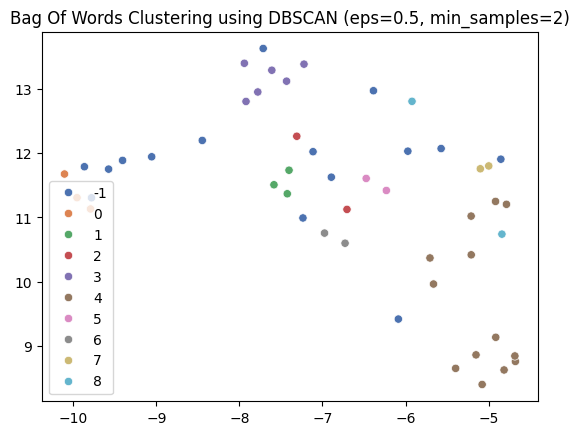

In [ ]:


model_bow = DBSCAN(eps=0.5,min_samples=2)
labels = model_bow.fit_predict(bow_embeddings)

print(labels)

for label in set(labels):
    print(f"Label: {label}")
    for i, l in enumerate(labels):
        if l == label:
            print(f"- Document {i}")


plot(bow_embeddings, labels, title="Bag Of Words Clustering using DBSCAN (eps=0.5, min_samples=2)")

In [76]:
possible_types = ask_a_question(ocrs=ocrs, model_for_QA=model_for_QA)

100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


In [129]:
umap_model = UMAP(n_components=2)
umap_bow_embedding = umap_model.fit_transform(bow_embeddings)

In [133]:
kmeans_model = KMeans(n_clusters=9, random_state=42)
kmeans_model.fit(embeddings)
labels = kmeans_model.labels_

# extended_X = np.concatenate([embeddings, X], axis=1)

# DBSCAN_model = DBSCAN(eps=3, min_samples=2)
# DBSCAN_model.fit(embeddings)
# labels = DBSCAN_model.labels_

# print(extended_X.shape)
# print(X.shape)

GMM_model = GaussianMixture(n_components=10, random_state=42)
GMM_model.fit(embeddings)
labels = GMM_model.predict(embeddings)

HBDSCAN_model = HDBSCAN(min_cluster_size=2, min_samples=2, metric='euclidean', cluster_selection_method='eom')
HBDSCAN_model.fit(embeddings)
labels = HBDSCAN_model.labels_

for label in set(labels):
    print(f"Cluster {label}:")
    for i, ocr_data in enumerate(ocrs):
        if labels[i] == label:
            print(f" - Document {i} - Possible types: {possible_types[i][0]} (confidence: {possible_types[i][1][0][0]*100 if len(possible_types[i][1]) > 0 else 'N/A'})")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



Cluster 0:
 - Document 2 - Possible types: ['The Police Commission'] (confidence: 97.4375)
 - Document 5 - Possible types: ['MERCED COUNTY DISTRICT ATTORNEY’S OFFICE'] (confidence: 99.8125)
 - Document 20 - Possible types: ['INFORMATION - FELONY'] (confidence: 97.5625)
 - Document 25 - Possible types: ['INFORMATION - FELONY'] (confidence: 97.5625)
Cluster 1:
 - Document 10 - Possible types: ['Incident Report Report Cover Sheet'] (confidence: 99.875)
 - Document 11 - Possible types: ['Incident Report Report Cover Sheet'] (confidence: 99.875)
Cluster 2:
 - Document 29 - Possible types: ['Report # 23-006308 - Supplement'] (confidence: 75.5625)
 - Document 49 - Possible types: ['Report', 'Supplement'] (confidence: 85.3125)
Cluster 3:
 - Document 18 - Possible types: ['INVESTIGATIVE REPORT'] (confidence: 95.3125)
 - Document 24 - Possible types: ['INVESTIGATIVE REPORT'] (confidence: 95.3125)
Cluster 4:
 - Document 37 - Possible types: ['Vehicle Detection Report'] (confidence: 99.875)
 - Doc

<Axes: title={'center': 'LayoutLMv3 Embeddings Clustering using HBDSCAN (min_cluster_size=2, min_samples=2)'}>

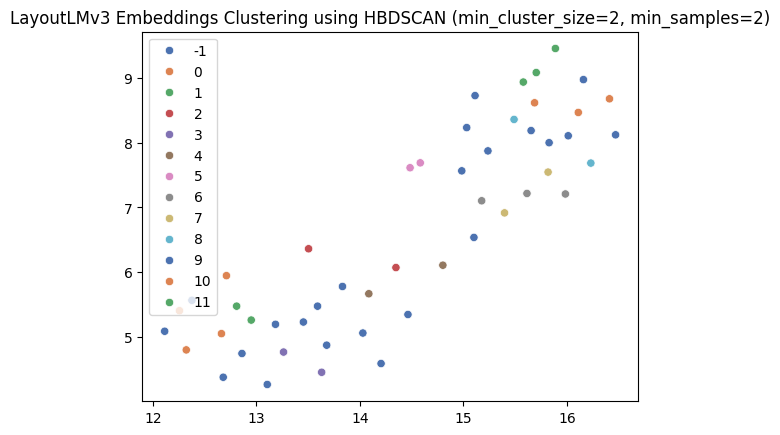

In [105]:
plot(embeddings, labels, title="LayoutLMv3 Embeddings Clustering using HBDSCAN (min_cluster_size=2, min_samples=2)")

In [103]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(embeddings, labels)
print("Silhouette Score:", silhouette)

from sklearn.metrics import calinski_harabasz_score

ch = calinski_harabasz_score(embeddings[labels != -1], labels[labels != -1])
print("Calinski-Harabasz Score:", ch)

Silhouette Score: 0.202055886387825
Calinski-Harabasz Score: 21.469362258911133


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



In [99]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3Model
feature_extractor = LayoutLMv3FeatureExtractor.from_pretrained("microsoft/layoutlmv3-base")

image = pages[0].convert("RGB")
print(image.size)
pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values


(1700, 2200)


In [91]:
from datasets import load_dataset

swag = load_dataset("swag", "regular")

from transformers import AutoTokenizer

tokenizer_bert = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

In [92]:
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer

BERT_model = AutoModelForMultipleChoice.from_pretrained("google-bert/bert-base-uncased")


Some weights of BertForMultipleChoice were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [223]:
swag["train"][0]


{'video-id': 'anetv_jkn6uvmqwh4',
 'fold-ind': '3416',
 'startphrase': 'Members of the procession walk down the street holding small horn brass instruments. A drum line',
 'sent1': 'Members of the procession walk down the street holding small horn brass instruments.',
 'sent2': 'A drum line',
 'gold-source': 'gold',
 'ending0': 'passes by walking down the street playing their instruments.',
 'ending1': 'has heard approaching them.',
 'ending2': "arrives and they're outside dancing and asleep.",
 'ending3': 'turns the lead singer watches the performance.',
 'label': 0}

In [ ]:
ending_names = ["ending0", "ending1", "ending2", "ending3"]

def preprocess_function(examples):
    first_sentences = [[context] * 4 for context in examples["sent1"]]
    question_headers = examples["sent2"]
    second_sentences = [
        [f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)
    ]

    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    tokenized_examples = tokenizer_bert(first_sentences, second_sentences, truncation=True)
    return {k: [v[i : i + 4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [186]:
tokenized_swag = swag.map(preprocess_function, batched=True)


Map:   0%|          | 0/73546 [00:00<?, ? examples/s]

Map:   0%|          | 0/20006 [00:00<?, ? examples/s]

Map:   0%|          | 0/20005 [00:00<?, ? examples/s]

In [ ]:
tokenized_swag["train"]

Dataset({
    features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 73546
})

In [93]:
prompt = "Members of the procession walk down the street holding small horn brass instruments. A drum line"
ending0 = 'passes by walking down the street playing their instruments.'
ending1 = 'has heard approaching them.'
ending2 = "arrives and they're outside dancing and asleep."
ending3 = 'turns the lead singer watches the performance.'

inputs = tokenizer_bert([[prompt, ending0], [prompt, ending1]], return_tensors="pt", padding=True)
labels = torch.tensor(0).unsqueeze(0)

In [94]:
labels

tensor([0])

In [95]:
outputs = BERT_model(**{k: v.unsqueeze(0) for k, v in inputs.items()}, labels=labels)
logits = outputs.logits
logits

tensor([[-0.1122, -0.0789]], grad_fn=<ViewBackward0>)

In [96]:
predicted_class = logits.argmax().item()
predicted_class

1

In [97]:
inputs.keys()

KeysView({'input_ids': tensor([[  101,  2372,  1997,  1996, 14385,  3328,  2091,  1996,  2395,  3173,
          2235,  7109,  8782,  5693,  1012,  1037,  6943,  2240,   102,  5235,
          2011,  3788,  2091,  1996,  2395,  2652,  2037,  5693,  1012,   102],
        [  101,  2372,  1997,  1996, 14385,  3328,  2091,  1996,  2395,  3173,
          2235,  7109,  8782,  5693,  1012,  1037,  6943,  2240,   102,  2038,
          2657,  8455,  2068,  1012,   102,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0]])})

In [ ]:


model_Top2Vec = Top2Vec(documents= list(contents), speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, hdbscan_args = hdbscan_args)
model_Top2Vec.get_num_topics()

2025-11-26 21:18:01,176 - top2vec - INFO - Pre-processing documents for training
2025-11-26 21:18:01,197 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
2025-11-26 21:18:04,829 - top2vec - INFO - Creating joint document/word embedding
2025-11-26 21:18:05,993 - top2vec - INFO - Creating lower dimension embedding of documents
2025-11-26 21:18:06,137 - top2vec - INFO - Finding dense areas of documents
2025-11-26 21:18:06,144 - top2vec - INFO - Finding topics


8

In [116]:
len(list(contents))

embedding_vectors = model.embed(list(contents))

from sklearn.metrics.pairwise import cosine_similarity

DBSCAN_model_top2vec = DBSCAN(eps=0.7,min_samples=2)

email = ["An email or letter From: someone To: someone. May contain a subject line (Subject), destination address, and send date."]


ref = 17
email_embedding = model.embed(email)


DBSCAN_model_top2vec.fit(embedding_vectors)
labels = DBSCAN_model_top2vec.labels_


scores = []
for i, l in enumerate(labels):
    if i == ref: scores.append(0); continue
    print(f"Document {i}: Cluster {l}")
    eucl = cosine_similarity(embedding_vectors[i].reshape(1,-1), email_embedding.reshape(1, -1))[0][0]
    scores.append(eucl)
    print(eucl)


scores = np.array(scores)
scores = np.nan_to_num(scores, nan=float('inf'))

print("Closest document to email description is document", np.argmax(np.array(scores)))
print(scores)

s=np.argsort(scores)[::-1]
print(s)

# topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["interview"], num_topics=2)

Document 0: Cluster -1
0.08418393
Document 1: Cluster 0
0.01769771
Document 2: Cluster 0
-0.0025720336
Document 3: Cluster -1
0.051670358
Document 4: Cluster -1
0.022193186
Document 5: Cluster -1
-0.012888661
Document 6: Cluster 1
0.12142245
Document 7: Cluster 2
-0.032092817
Document 8: Cluster 3
0.037559263
Document 9: Cluster 3
0.037559263
Document 10: Cluster 4
0.03004166
Document 11: Cluster 4
0.03004166
Document 12: Cluster 5
0.13193823
Document 13: Cluster 5
0.13193823
Document 14: Cluster -1
0.01994699
Document 15: Cluster -1
0.048285455
Document 16: Cluster -1
0.04909259
Document 18: Cluster 7
0.082634225
Document 19: Cluster 4
0.08022027
Document 20: Cluster 8
0.076623715
Document 21: Cluster 9
0.2115505
Document 22: Cluster 6
0.08904345
Document 23: Cluster 6
0.081112444
Document 24: Cluster 7
0.082634225
Document 25: Cluster 8
0.076623715
Document 26: Cluster 9
0.2115505
Document 27: Cluster -1
0.085216224
Document 28: Cluster 1
0.0709963
Document 29: Cluster 10
0.0814564
D

In [540]:
np.allclose(embedding_vectors[14], embedding_vectors[8])

False

<Axes: >

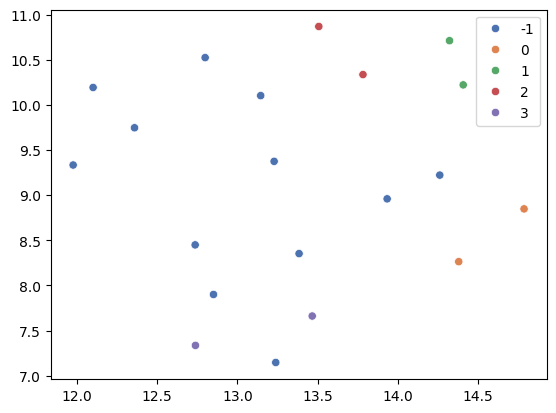

In [537]:
umaps = UMAP().fit_transform(embedding_vectors)
umaps
sns.scatterplot(x=umaps[:,0], y=umaps[:,1], hue=labels, palette="deep")
